# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import flatiron_stats as fs


In [2]:
#Your code here
df=pd.read_csv('homepage_actions.csv')

In [3]:
df.columns,df.index


(Index(['timestamp', 'id', 'group', 'action'], dtype='object'),
 RangeIndex(start=0, stop=8188, step=1))

In [4]:
df.describe()

,id
count,8188.000000
mean,564699.749878
std,219085.845672
min,182988.000000
25%,373637.500000
50%,566840.500000
75%,758078.000000
max,937217.000000


In [5]:
df['group'].unique()

array(['experiment', 'control'], dtype=object)

In [6]:
df['action'].unique()

array(['view', 'click'], dtype=object)

In [7]:
df.action.value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [8]:
df


,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
...,...,...,...,...
8183,2017-01-18 09:11:41.984113,192060,experiment,view
8184,2017-01-18 09:42:12.844575,755912,experiment,view
8185,2017-01-18 10:01:09.026482,458115,experiment,view
8186,2017-01-18 10:08:51.588469,505451,control,view


In [9]:
df[df['id'] == 349125]

,timestamp,id,group,action
7,2016-09-24 20:57:20.336757,349125,experiment,view
8,2016-09-24 20:58:01.948663,349125,experiment,click


In [10]:
# draft, WIP
l=list(df.loc[df['action'] == 'click']['id'])
for elem in l:
    if elem == 349125:
        print (elem)
l2=df.loc[df['action'] == 'view']['id']
for elem in l2:
    if elem == 349125:
        print (elem)


349125
349125


In [11]:
# <1>* How many viewers also clicked?
# Looking for duplicated id (multiple rows with same id) and whether there were clicks and views for that id.
dfeda= df.copy()
dfeda['temp']=1
dfsort=dfeda.groupby(by = ['id']).sum()
dfsort.describe()
# interpretation: at a maximum, a given user appears twice in the dataframe.
# it could be click&click click&view view&click view&view (order matters)
# we are looking for view&click
# cids = set ( df[df.action == 'click'])

# set of unique users' ids who clicked
cids = set ( df[df.action == 'click']['id'].unique() ) 
# set of unique users' ids who viewed
vids = set ( df[df.action == 'view']['id'].unique() ) 

print("Number of viewers: {} \tNumber of clickers: {}".format(len(vids), len(cids)))

#     * Are there any anomalies with the data; did anyone click who didn't view?

for idnum in list(df.loc[df['action'] == 'click']['id']):
    if idnum in list(df.loc[df['action'] == 'view']['id']):
        pass
    else:
        print ( idnum , "clicked but didn't view")

# Comment: Everyone who clicked, also viewed the homepage! 
# (Thank goodness!)        
                              



Number of viewers: 6328 	Number of clickers: 1860


In [12]:
#     * Is there any overlap between the control and experiment groups? 
dfc=df.loc[df['group'] == 'control']
dfe=df.loc[df['group'] == 'experiment']
print(dfc.shape,dfe.shape,df.shape)
# result: # of controls + number of experiments = total number
print(dfc.sort_values(by='timestamp').iloc[0])
print(dfe.sort_values(by='timestamp').iloc[0])
print(dfc.sort_values(by='timestamp').iloc[-1])
print(dfe.sort_values(by='timestamp').iloc[-1])

# result: control and experiment were taken at the same time period



(4264, 4) (3924, 4) (8188, 4)
timestamp    2016-09-24 19:59:02.646620
id                               671993
group                           control
action                             view
Name: 3, dtype: object
timestamp    2016-09-24 17:42:27.839496
id                               804196
group                        experiment
action                             view
Name: 0, dtype: object
timestamp    2017-01-18 10:24:08.629327
id                               461199
group                           control
action                             view
Name: 8187, dtype: object
timestamp    2017-01-18 10:01:09.026482
id                               458115
group                        experiment
action                             view
Name: 8185, dtype: object


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

0.21780000000000002 0.235 0.0012900606060606066 0.002178787878787879


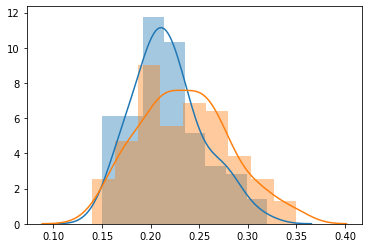

In [13]:
#Your code here

# metric = rate of # of clicks with respect to # of views

# H0 : the experimental homepage was no more effective than that of the control group
#     ie. click rate of experiemnt population is smaller or equal to click rate of control population

# Ha: click rate mean is higher for experiment than for control populations

# alpha = 0.05

# Decide which test to do.
# let's take some samples and see ...
smpl_sz=100

ctrl=[]
exp=[]

ndraws = 100
for i in range(ndraws):

    smpl_ctrl= np.random.choice(dfc['action'],smpl_sz)
    ctrl.append ( list(smpl_ctrl).count('click') / smpl_sz )

    smpl_exp= np.random.choice(dfe['action'],smpl_sz)
    exp.append ( list(smpl_exp).count('click') / smpl_sz )

# print(ctrl,exp)

print(np.mean(ctrl),np.mean(exp),np.var(ctrl,ddof=1),np.var(exp,ddof=1))

sns.distplot(ctrl)
sns.distplot(exp)
plt.show()

# Here I got 2 lists of click rates coming from random choices either from control or experiment.
# I was in the mindset of using these 2 lists as samples for the Welch t-test.
# BUT 
# The flatiron solution is to use the control and experiment data as the 2 only samples see below.

                       timestamp      id    group action  count
3     2016-09-24 19:59:02.646620  671993  control   view      1
9     2016-09-24 21:00:12.278374  560027  control   view      1
23    2016-09-25 00:25:14.141290  281985  control   view      1
24    2016-09-25 01:14:48.603202  407864  control   view      1
25    2016-09-25 02:16:11.046654  342984  control   view      1
...                          ...     ...      ...    ...    ...
8178  2017-01-18 08:17:12.675797  616692  control   view      1
8181  2017-01-18 09:07:37.661143  795585  control   view      1
8182  2017-01-18 09:09:17.363917  795585  control  click      1
8186  2017-01-18 10:08:51.588469  505451  control   view      1
8187  2017-01-18 10:24:08.629327  461199  control   view      1

[4264 rows x 5 columns] 
 action  click  view
id                 
182994    1.0   1.0
183089    NaN   1.0
183248    1.0   1.0
183515    NaN   1.0
183524    NaN   1.0
...       ...   ...
936786    NaN   1.0
937003    NaN   1.0
93707

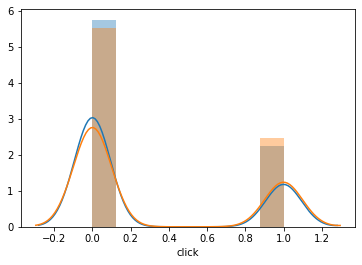

In [14]:
# Flatiron solution approach:

df['count'] = 1

#Convert clicks into a binary variable on a user-by-user-basis
control = df[df.group =='control'].pivot(index ='id', columns = 'action' , values = 'count')
print(df[df.group =='control'],'\n', control) 
control=control.fillna(value=0)
print('\n', control) 
print(control.describe())

experiment = df[df.group =='experiment'].pivot(index ='id', columns = 'action' , values = 'count')
experiment=experiment.fillna(value=0)
print(experiment.describe())

print("Sample sizes: \t Control: {} \t Experiment: {}".format(len(control),len(experiment)))
print("Total Clicks: \t Control: {} \t Experiment: {}".format(control['click'].sum(),experiment['click'].sum()))
print("Average click rate: \t Control: {} \t Experiment: {}".format(control['click'].mean(),experiment['click'].mean()))

#Then run Welch's test on control['click'] and experiment['click']
sns.distplot(control['click'])
sns.distplot(experiment['click'])
plt.show()

In [15]:
df.head()

,timestamp,id,group,action,count
0,2016-09-24 17:42:27.839496,804196,experiment,view,1
1,2016-09-24 19:19:03.542569,434745,experiment,view,1
2,2016-09-24 19:36:00.944135,507599,experiment,view,1
3,2016-09-24 19:59:02.646620,671993,control,view,1
4,2016-09-24 20:26:14.466886,536734,experiment,view,1


In [16]:
control,experiment

(action  click  view
 id                 
 182994    1.0   1.0
 183089    0.0   1.0
 183248    1.0   1.0
 183515    0.0   1.0
 183524    0.0   1.0
 ...       ...   ...
 936786    0.0   1.0
 937003    0.0   1.0
 937073    0.0   1.0
 937108    0.0   1.0
 937217    1.0   1.0
 
 [3332 rows x 2 columns], action  click  view
 id                 
 182988    0.0   1.0
 183136    0.0   1.0
 183141    1.0   1.0
 183283    0.0   1.0
 183389    0.0   1.0
 ...       ...   ...
 935382    0.0   1.0
 935576    0.0   1.0
 935742    1.0   1.0
 936129    0.0   1.0
 937139    1.0   1.0
 
 [2996 rows x 2 columns])

In [17]:
# continuing on the path taken from the Flatiron solution...

#click rates:
cr_ctrl=control['click'].mean()
cr_exp=experiment['click'].mean()

print(cr_ctrl,cr_exp)

# variance
var_ctrl=control['click'].var(ddof=1)
var_exp=experiment['click'].var(ddof=1)
print(var_ctrl,var_exp)

# sample_size
sz_ctrl = len(control['click'])
sz_exp = len(experiment['click'])
print(sz_ctrl,sz_exp)


0.2797118847539016 0.3097463284379172
0.20153363056420406 0.2138749272820076
3332 2996


In [23]:
# different sizes, different variances, difference means => Welch's t-test
# Welch's test
a=np.array(control['click'])
b=np.array(experiment['click'])

# Calculate Welch's t statistic for two samples.
numerator = a.mean() - b.mean()
denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
t_stat=np.abs(numerator/denominator)

# Calculate the effective degrees of freedom for two samples.
s1 = a.var(ddof=1)
s2 = b.var(ddof=1)
n1 = a.size
n2 = b.size
numerator = (s1/n1 + s2/n2)**2
denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
dof=numerator/denominator

# p_value - 1-tailed test
p = 1-stats.t.cdf(np.abs(t_stat), dof)

# t-critical corresponding to alpha=0.05
t_crit=stats.t.ppf(.95,dof)

print(t_stat,dof,p,t_crit)

2.615440020788211 6211.149291520621 0.004466402814337078 1.6450989918196057


In [24]:
# conclusion:
# p_value < alpha
# t_stat>t_crit
# We can reject H0
# We accept Ha is true.

In [25]:
fs.p_value_welch_ttest(control.click, experiment.click,two_sided = False)
# returns p-value and dof

(0.004466402814337078, 6211.149291520621)

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [36]:
#Your code here
# click-through rate as that of the control group
cr_ctrl = control['click'].mean()
print( control['click'].sum()/len(control['click']),
       control['click'].mean() )
# (just checking they are the same )

# number of clicks for the experiment group
cnum_exp_theory=len(experiment['click']) * cr_ctrl
print(cnum_exp_theory)

0.2797118847539016 0.2797118847539016
838.0168067226891


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [45]:
#Your code here
cnum_exp_actual = experiment['click'].sum()

n= len(experiment)
p=cr_ctrl
var  = n*p*(1-p)
std=np.sqrt(var)
print(var, std)
z_score=(cnum_exp_actual - cnum_exp_theory)/std
print(z_score)

603.6135462588397 24.568547907005815
3.6625360854823588


### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [47]:
#Your code here
p_val=1-stats.norm.cdf(z_score)
p_val

0.00012486528006949715

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **Your analysis here**
# Comment: Yes, while the p-value is slightly lower, 
# both would lead to confident rejection of the null hypothesis. 
# The experimental page appears to be a more effective design.

## WARNING: 
### dof from Welch's test is a huge value. Does it make sense?
### var and std in z-test is a huge value. Does it make sense?

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.